<a href="https://colab.research.google.com/github/Poornasri2003/Stone_Segmentation/blob/main/HallibutonStoneSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Libraries for Data Manipulation and Analysis
import pandas as pd
import os
import ast
import numpy as np

# Libraries for Image Processing and Visualization
import torch
from PIL import Image
import requests
import concurrent.futures as futures
import matplotlib.pyplot as plt
import io
import cv2
import matplotlib.patches as patches


In [3]:
# Mounting to drive for Dataset
origin = '/content/drive/MyDrive/Dataset/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Locale module for setting preferred encoding to UTF-8
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!rm -r 'data'

rm: cannot remove 'data': No such file or directory


In [6]:
# Create directory structure for storing training and testing data images and labels under the 'path' directory
path = 'data'
os.mkdir(path)

# Create directories for training data
os.mkdir(os.path.join(path, 'train'))
os.mkdir(os.path.join(path, 'train', 'images'))
os.mkdir(os.path.join(path, 'train', 'labels'))

# Create directories for testing data
os.mkdir(os.path.join(path, 'test'))
os.mkdir(os.path.join(path, 'test', 'images'))
os.mkdir(os.path.join(path, 'test', 'labels'))


In [7]:
# Define a function to retrieve filenames without label from a specified directory
def get_filenames_without_label(directory):
  filenames = []
  for filename in os.listdir(directory):
    if not filename.endswith('label.jpg'):
      filenames.append(filename)
  return filenames

filenames = get_filenames_without_label(origin)
filenames

['Image05.JPG',
 'Image01.JPG',
 'Image02.JPG',
 'Image15.JPG',
 'Image04.JPG',
 'Image13.JPG',
 'Image19.JPG',
 'Image16.JPG',
 'Image20.JPG',
 'Image03.JPG',
 'Image11.JPG',
 'Image17.JPG',
 'Image07.JPG',
 'Image12.JPG',
 'Image09.JPG',
 'Image08.JPG',
 'Image10.JPG',
 'Image14.JPG',
 'Image06.JPG',
 'Image18.JPG']

In [8]:
from shapely.geometry import Polygon
# Conversion of masks to polygons
def polygon_conversion(img_path, mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert mask to boolean for efficient contour detection
    mask = mask.astype(bool)

    # Find external contours using CHAIN_APPROX_SIMPLE for better memory usage
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("Number of contours found:", len(contours))
    # Initialize empty lists for polygons and normalized polygons
    polygons = []
    normalized_polygons = []

    for contour in contours:

        # Handle potential errors during polygon extraction
        if len(contour) < 4:
            continue  # Skip contours with less than 4 vertices (invalid polygons)

        polygon = contour.reshape(-1, 2).tolist()

        # Normalize coordinates for YOLOv8 (0-1 range)
        normalized_polygon = [[round(coord[0] / mask.shape[1], 4), round(coord[1] / mask.shape[0], 4)] for coord in polygon]

        # Create Shapely polygons (simplified with 0.85 tolerance and topology preservation)
        polygon_shapely = Polygon(polygon)
        simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
        polygons.append(simplified_polygon)
        normalized_polygons.append(Polygon(normalized_polygon))

    return polygons, normalized_polygons

In [9]:
test_image = 'Image10'
poly, norm_poly = polygon_conversion(origin+f'/{test_image}.JPG', origin+f'/{test_image}_label.jpg')

Number of contours found: 3760


Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 8 vertices:
Polygon with 6 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 4 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 6 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 7 vertices:
Polygon with 9 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 7 vertices:
Polygon with 6 vertices:
Polygon with 13 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 6 vertices:
Polygon with 6 vertices:
Polygon with 5 vertices:
Polygon with 4 vertices:
Polygon with 5 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 6 vertices:
Polygon with 5 vertices:
Polygon with 6 vertices:
Polygon with 5 vertices:
Polygon with 276 vertices:
Polygon with 5 vertice

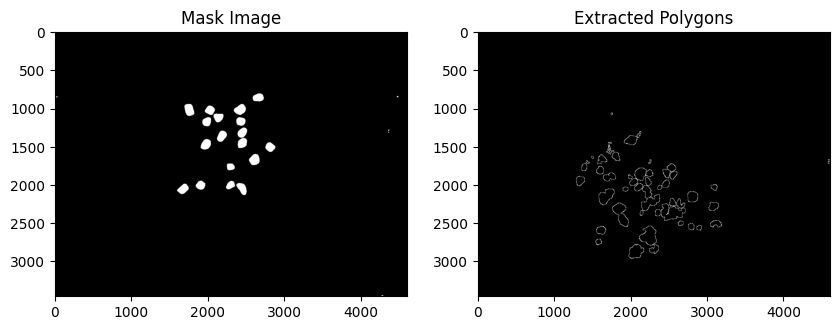

In [10]:
# Visualize Extracted Polygons on a Black Image

# Load the mask image and the original image (assuming grayscale for mask)
mask_image = cv2.imread(origin+'/Image01_label.jpg', cv2.IMREAD_GRAYSCALE)
original_image = cv2.imread(origin+'/Image01.JPG')

# Create a black image to clearly display the polygons
black_image = np.zeros_like(original_image)

# Extract polygon coordinates (x and y) for plotting
polygons = poly  # Assuming 'poly' contains the extracted polygons

# Iterate through each polygon and plot its coordinates on the black image
for polygon in polygons:
    x, y = polygon.exterior.xy

    # Print the number of vertices for informative debugging (optional)
    print(f"Polygon with {len(x)} vertices:")

    # Convert coordinates to a NumPy array for OpenCV's polylines function
    points = np.array([np.array(list(zip(x, y)))], dtype=np.int32)

    # Draw the polygon on the black image with white color and thickness of 2
    cv2.polylines(black_image, points, True, (255, 255, 255), 2)

# Display the images: mask image and black image with plotted polygons
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask_image, cmap='gray')  # Grayscale colormap for mask
plt.title('Mask Image')
plt.subplot(1, 2, 2)
plt.imshow(black_image)
plt.title('Extracted Polygons')
plt.show()



In [11]:
def get_data(image_path, mask_path, flag = 'train'):
      try:
        image_file = 'data/{1}/images/{0}'.format(image_path, flag)
        image_txt  = 'data/{1}/labels/{0}.txt'.format(image_path.split('.JPG')[0], flag)

        image = Image.open(origin+'/'+image_path)
        fp = open(image_txt,'w')
        poly, norm_poly = polygon_conversion(origin+'/'+image_path, origin+'/'+mask_path)
        cnt = 0
        for polygon in norm_poly:
          poly_coor = '0 '
          x, y = polygon.exterior.xy
          x = np.array(x)
          y = np.array(y)
          if len(x) > 50:
            cnt += 1

            for iter in range(len(x)):

              poly_coor += str(x[iter])+' '
              poly_coor += str(y[iter])+' '

            poly_coor += '\n'
            fp.write(poly_coor)

        image.save(image_file)

        print(image_txt, cnt)

      except Exception as e:
        print(e)

In [12]:
for i in filenames[:17]:
  get_data(i ,i.replace('.JPG', '_label.jpg'))

Number of contours found: 1331
data/train/labels/Image05.txt 12
Number of contours found: 1746
data/train/labels/Image01.txt 21
Number of contours found: 735
data/train/labels/Image02.txt 7
Number of contours found: 3932
data/train/labels/Image15.txt 52
Number of contours found: 1332
data/train/labels/Image04.txt 10
Number of contours found: 4030
data/train/labels/Image13.txt 49
Number of contours found: 3788
data/train/labels/Image19.txt 49
Number of contours found: 3361
data/train/labels/Image16.txt 48
Number of contours found: 3223
data/train/labels/Image20.txt 47
Number of contours found: 1709
data/train/labels/Image03.txt 22
Number of contours found: 3939
data/train/labels/Image11.txt 46
Number of contours found: 4105
data/train/labels/Image17.txt 53
Number of contours found: 4627
data/train/labels/Image07.txt 66
Number of contours found: 4039
data/train/labels/Image12.txt 51
Number of contours found: 3569
data/train/labels/Image09.txt 45
Number of contours found: 3934
data/train/

In [13]:
for i in filenames[17:]:
  get_data(i ,i.replace('.JPG', '_label.jpg'), flag = 'test')

Number of contours found: 3895
data/test/labels/Image14.txt 52
Number of contours found: 3918
data/test/labels/Image06.txt 49
Number of contours found: 4011
data/test/labels/Image18.txt 55


In [16]:
# Initialize list and counter
image_files = []
cnt = 0


In [17]:
# Iterate through image files in the 'train/images' directory
for filename in os.listdir(path + '/train/images/'):
    # Check if the file has a supported image extension (case-insensitive)
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        # Construct the corresponding label file path
        image_txt = path + '/train/labels/' + os.path.splitext(filename)[0] + '.txt'
        if os.path.exists(image_txt):

            image_files.append(os.path.join(path + '/train/images/', filename))
            cnt += 1

In [18]:
# Create and Write Image Paths to 'train.txt' File

with open(path + "/train/train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image + '\n')

print(f"Created 'train.txt' with {cnt} image-label pairs.")

Created 'train.txt' with 17 image-label pairs.


In [20]:
# Check Data Consistency in Training Dataset Folder

# Count the number of label files in the 'labels' subfolder
num_label_files = len(os.listdir(path + '/train/labels/'))
print(f"Number of label files in 'train/labels/': {num_label_files}")

# Count the number of image files in the 'images' subfolder
num_image_files = len(os.listdir(path + '/train/images/'))
print(f"Number of image files in 'train/images/': {num_image_files}")

# Count the number of lines in the 'train.txt' file (assuming one line per image)
with open(path + "/train/train.txt", 'r') as fp:
    num_entries_in_txt = len(fp.readlines())
print(f"Number of entries in 'train.txt': {num_entries_in_txt}")


Number of label files in 'train/labels/': 17
Number of image files in 'train/images/': 17
Number of entries in 'train.txt': 17


In [24]:
# Create a test.txt file
image_files = []
cnt = 0
for filename in os.listdir(path +'/test/images/'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png")  or filename.endswith(".JPG"):
        image_txt  = path +'/test/labels/{0}.txt'.format(str(filename.split('/')[-1]).split('.')[0])
        if os.path.exists(image_txt):
          image_files.append(path +"/test/images/" + filename)
          cnt += 1

with open(path + "/test/test.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()

In [25]:
# Count Number of Files in Test Data Directories
# Count label files in 'test/labels' directory
num_label_files = len(os.listdir(os.path.join(path, 'test/labels')))
print(f"Number of label files in 'test/labels/': {num_label_files}")

# Count image files in 'test/images' directory
num_image_files = len(os.listdir(os.path.join(path, 'test/images')))
print(f"Number of image files in 'test/images/': {num_image_files}")

# Count lines in 'test.txt' file
with open(os.path.join(path, "test/test.txt"), 'r') as fp:
    num_entries_in_txt = len(fp.readlines())
    print(f"Number of entries in 'test.txt': {num_entries_in_txt}")

Number of label files in 'test/labels/': 3
Number of image files in 'test/images/': 3
Number of entries in 'test.txt': 3


In [26]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [27]:
# Load yolo segmentation model
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.73M/6.73M [00:00<00:00, 62.8MB/s]


In [28]:
# Train YOLOv8 model
model.train(data="/content/data.yaml", epochs= 100, imgsz=640)

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 85.2MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 85.57it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/test/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 21.13it/s]

val: New cache created: /content/data/test/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.26G      1.404      2.119      3.655     0.9564         49        640: 100%|██████████| 2/2 [00:06<00:00,  3.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          3        156     0.0111     0.0641    0.00592    0.00261     0.0178      0.103    0.00997    0.00467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.41G       1.44      2.335      3.606      1.022         53        640: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all          3        156     0.0244      0.141     0.0146    0.00627     0.0278       0.16     0.0173     0.0079



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.36G      1.257      2.355      3.492     0.9336         25        640: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all          3        156     0.0356      0.205     0.0256     0.0121     0.0467      0.269     0.0358      0.015



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.67G      2.001      2.667      3.531      1.041        146        640: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all          3        156     0.0489      0.282     0.0406     0.0188     0.0533      0.308     0.0456     0.0199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.62G      1.561      2.189      3.244     0.9929         31        640: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all          3        156     0.0722      0.417       0.07     0.0284     0.0822      0.474     0.0853     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.53G      1.557      2.149      2.904     0.9188         88        640: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all          3        156     0.0822      0.474     0.0879     0.0421     0.0911      0.526      0.109     0.0517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.39G      1.632      1.982      2.225      0.887         19        640: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all          3        156     0.0889      0.513      0.105     0.0481     0.0967      0.558      0.113     0.0523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.63G      1.751      2.043      1.875     0.8954        122        640: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all          3        156        0.1      0.577      0.124     0.0506      0.108      0.622      0.148     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.4G      1.667      2.235      1.377     0.8992         49        640: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all          3        156      0.101      0.583      0.126     0.0523      0.109      0.628      0.154     0.0675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.57G      1.416      1.848      1.256     0.9129         37        640: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all          3        156      0.103      0.596      0.142     0.0612      0.112      0.647       0.17     0.0776

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.49G       1.63       2.05      1.254     0.8977        102        640: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all          3        156      0.101      0.583      0.217      0.102      0.114       0.66      0.259      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.64G      1.302      1.774       1.29     0.8843         25        640: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all          3        156      0.104      0.603      0.308      0.149      0.114       0.66      0.344       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.41G      1.406      1.774      1.192     0.8906         43        640: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all          3        156      0.106      0.609      0.353      0.171      0.116      0.667      0.364      0.175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.21G      1.418      1.862      1.224     0.8863        135        640: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all          3        156      0.108      0.622      0.335      0.174      0.116      0.667      0.332      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.5G      1.336      1.814      1.033     0.8839         56        640: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all          3        156      0.109      0.628      0.326      0.182      0.117      0.673      0.337      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.53G      1.171      1.512      1.054     0.8902         78        640: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all          3        156      0.111      0.641      0.382      0.232      0.121      0.699      0.406      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.51G      1.189       1.72      1.067     0.8557         57        640: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all          3        156      0.116      0.667      0.414      0.267      0.124      0.718      0.418      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.57G      1.208      1.648      0.979     0.8833         50        640: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          3        156      0.122      0.705      0.467      0.304      0.129      0.744      0.479      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.4G      1.121       1.58     0.9626     0.8366         37        640: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all          3        156      0.124      0.718      0.489      0.327      0.128      0.737      0.509       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.84G      1.388      1.764      1.121     0.9071        170        640: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


                   all          3        156      0.124      0.718      0.511       0.33      0.129      0.744      0.531      0.309

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.51G      1.168      2.152     0.9255     0.8782         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all          3        156      0.126      0.724      0.514      0.342      0.127      0.731      0.525      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.78G      1.442      1.965      1.039     0.8856        134        640: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all          3        156      0.122      0.705      0.493      0.323      0.121      0.699       0.49      0.263

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       3.4G      1.052       1.38       1.14     0.8556         29        640: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all          3        156      0.123      0.712        0.5      0.324      0.124      0.718      0.503      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.08G      1.308      1.743      1.007     0.8763        119        640: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all          3        156      0.126      0.724      0.505      0.326      0.122      0.705      0.495      0.263

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.24G      1.171      1.598     0.9376     0.9208         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all          3        156      0.124      0.718      0.461      0.303      0.126      0.724      0.449      0.241



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.57G     0.9005      1.156      0.872     0.8705          9        640: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          3        156      0.127      0.731      0.463      0.296      0.123      0.712      0.453      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.26G      1.244      1.476     0.9327     0.8609         60        640: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

                   all          3        156      0.128      0.737      0.473      0.309      0.121      0.699      0.459       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.55G      1.174      1.302     0.8872     0.8717         50        640: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all          3        156      0.128      0.737      0.473      0.309      0.121      0.699      0.459       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.34G      1.161       1.46     0.8971     0.9024         46        640: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all          3        156      0.126      0.724      0.484       0.31       0.12      0.692      0.466       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.41G      1.279       1.51     0.8658      0.875        111        640: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          3        156      0.123      0.712       0.47      0.279      0.118      0.679      0.434      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.35G      1.206      1.601      1.337     0.8705         13        640: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all          3        156      0.123      0.712       0.47      0.279      0.118      0.679      0.434      0.215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.42G      1.234      1.425     0.8672     0.8775         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all          3        156      0.126      0.724      0.513      0.315      0.121      0.699      0.507      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.38G      1.082       1.29     0.8404     0.8956         74        640: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all          3        156      0.123      0.712      0.544      0.362      0.126      0.724      0.569      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.51G      1.255      1.592     0.9091     0.8802        132        640: 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all          3        156      0.123      0.712      0.544      0.362      0.126      0.724      0.569      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.47G      1.258      1.481     0.8307     0.8576         55        640: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]

                   all          3        156      0.126      0.724      0.542      0.348      0.127      0.731      0.569      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.54G      1.099      1.406     0.8881     0.8852         41        640: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all          3        156      0.127      0.731      0.563      0.335      0.123      0.712      0.545      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.36G      1.157      1.379     0.8171     0.8999         41        640: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all          3        156      0.127      0.731      0.563      0.335      0.123      0.712      0.545      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.25G      1.299      1.783      0.864     0.8748         63        640: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all          3        156      0.127      0.731      0.572      0.321       0.12      0.692      0.525      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.28G      1.156      1.397     0.7721     0.8651         49        640: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all          3        156      0.124      0.718      0.583      0.339      0.123      0.712      0.592      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.51G     0.9718      1.241     0.8407     0.8535         13        640: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all          3        156      0.124      0.718      0.583      0.339      0.123      0.712      0.592      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.53G      1.296      1.503     0.8655     0.8861         61        640: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all          3        156      0.158       0.66      0.609      0.356      0.552      0.615      0.613      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100       3.4G      1.148      1.454     0.8123     0.8686         65        640: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


                   all          3        156      0.792      0.514      0.597      0.355      0.854        0.5      0.631      0.301

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.39G      1.171      1.558     0.8483     0.8719         52        640: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all          3        156      0.792      0.514      0.597      0.355      0.854        0.5      0.631      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.52G      1.152      1.457     0.7914     0.8604         73        640: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all          3        156      0.845      0.386      0.615      0.366      0.845      0.386      0.607      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.54G       1.18      1.335     0.7923     0.8711         78        640: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all          3        156      0.845      0.386      0.615      0.366      0.845      0.386      0.607      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.59G      1.143      1.443     0.8222     0.8791         55        640: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]

                   all          3        156      0.899      0.346      0.633      0.393      0.899      0.346      0.619      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.46G      1.273      1.517     0.8087      0.855         95        640: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]


                   all          3        156      0.899      0.346      0.633      0.393      0.899      0.346      0.619      0.307

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100       3.4G      0.986      1.166      7.107     0.8569          4        640: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all          3        156       0.88      0.376      0.641      0.404      0.895      0.383      0.635      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.32G     0.9799      1.134     0.8055     0.8597         11        640: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all          3        156       0.88      0.376      0.641      0.404      0.895      0.383      0.635      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.64G      1.174      1.622     0.7906     0.8677         48        640: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all          3        156      0.853      0.519      0.659      0.421      0.864      0.526      0.661      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.24G      1.121       1.54      0.837     0.9073         57        640: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


                   all          3        156      0.853      0.519      0.659      0.421      0.864      0.526      0.661      0.354

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.22G     0.9849      1.286     0.7857     0.8413         58        640: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          3        156      0.838      0.532      0.668      0.418      0.849      0.539      0.671      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.69G      1.096      1.406     0.8068     0.8648         41        640: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all          3        156      0.838      0.532      0.668      0.418      0.849      0.539      0.671      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.46G       1.28      1.762     0.8289     0.9074         61        640: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


                   all          3        156      0.785      0.607      0.656      0.378      0.696      0.538      0.571      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.53G      1.176      1.654     0.8132     0.8799         36        640: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all          3        156      0.785      0.607      0.656      0.378      0.696      0.538      0.571      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.51G      1.389      1.695     0.9073     0.9234         35        640: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all          3        156      0.737      0.646      0.656      0.406       0.67      0.586      0.608      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.37G      1.033       1.36     0.8437     0.8563         60        640: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          3        156      0.737      0.646      0.656      0.406       0.67      0.586      0.608      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.46G      1.078      1.287     0.7759     0.8564         63        640: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all          3        156      0.773      0.679      0.699      0.451      0.751       0.66      0.701      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.45G      1.003      1.647      0.805     0.8739         16        640: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all          3        156      0.773      0.679      0.699      0.451      0.751       0.66      0.701      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.66G     0.8369     0.9245     0.6281     0.8325         19        640: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all          3        156      0.787      0.679      0.712      0.465      0.785      0.673      0.722      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.45G      1.113      1.611     0.7698     0.9417         51        640: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all          3        156      0.787      0.679      0.712      0.465      0.785      0.673      0.722      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.44G      1.498      1.781     0.8365     0.8832        145        640: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all          3        156      0.805      0.679       0.72      0.482      0.773      0.654      0.706      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100       3.6G      1.124       1.43     0.7461     0.8732         99        640: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all          3        156      0.805      0.679       0.72      0.482      0.773      0.654      0.706      0.379



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.44G     0.9325      1.104     0.8047     0.8802         23        640: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all          3        156      0.771      0.713      0.701      0.457      0.716      0.646      0.675      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.45G      1.102       1.52     0.7585     0.8428         64        640: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all          3        156      0.771      0.713      0.701      0.457      0.716      0.646      0.675      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.57G      1.106      1.377     0.7243     0.8847         47        640: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all          3        156      0.773        0.7      0.708      0.464       0.72      0.644      0.684      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.32G      1.073       1.44     0.8614     0.8929         76        640: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all          3        156      0.773        0.7      0.708      0.464       0.72      0.644      0.684      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.31G      1.051      1.602      0.796     0.8604         95        640: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all          3        156      0.789      0.718      0.719      0.478       0.76      0.692       0.71       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.55G      1.076      1.394     0.8276     0.8656        130        640: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all          3        156      0.789      0.718      0.719      0.478       0.76      0.692       0.71       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.51G      1.173      1.332     0.7596     0.8544         99        640: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all          3        156      0.803      0.718      0.727      0.482      0.781      0.699      0.704       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.56G      1.136       1.35     0.8158     0.8465         51        640: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all          3        156      0.803      0.718      0.727      0.482      0.781      0.699      0.704       0.37

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.46G      1.192      1.379     0.7815     0.8716         66        640: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all          3        156      0.794      0.712      0.725      0.482      0.751      0.677      0.689       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.49G      0.993      1.311     0.6884     0.8605         36        640: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


                   all          3        156      0.794      0.712      0.725      0.482      0.751      0.677      0.689       0.36

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.28G      1.078      1.174     0.7424     0.8885         45        640: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          3        156      0.786      0.707      0.719      0.467      0.797       0.63      0.694      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.43G      1.058      1.153     0.6856      0.858         61        640: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all          3        156      0.786      0.707      0.719      0.467      0.797       0.63      0.694      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.58G      1.112      1.423     0.7911     0.8714         48        640: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


                   all          3        156      0.801      0.697      0.715      0.468       0.82      0.628      0.703      0.362

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.53G     0.8876       1.08     0.6723     0.8517         45        640: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all          3        156      0.801      0.697      0.715      0.468       0.82      0.628      0.703      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.35G      1.198      1.232     0.7253     0.8647         97        640: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all          3        156      0.797      0.706      0.721       0.48      0.756      0.699      0.715      0.392

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.42G     0.8271      1.038     0.6505     0.8602         14        640: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all          3        156      0.797      0.706      0.721       0.48      0.756      0.699      0.715      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.43G      1.108       1.37     0.7592     0.8676        101        640: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all          3        156      0.813      0.723      0.725      0.479      0.772      0.692      0.708      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.72G     0.9862        1.2     0.7329     0.8361         84        640: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all          3        156      0.813      0.723      0.725      0.479      0.772      0.692      0.708      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.42G      1.247      1.475     0.7603     0.8584        111        640: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all          3        156      0.817      0.716      0.727      0.481      0.788      0.691      0.721      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.74G     0.8797      1.222     0.6776     0.8338         23        640: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


                   all          3        156      0.817      0.716      0.727      0.481      0.788      0.691      0.721      0.404

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.57G     0.9873      1.231     0.7036     0.8289         49        640: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all          3        156      0.813      0.705      0.726       0.48      0.772      0.679      0.726      0.383

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.38G      1.072      1.294     0.6977     0.8446         76        640: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all          3        156      0.813      0.705      0.726       0.48      0.772      0.679      0.726      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.49G      1.293      1.594     0.7382     0.8729        110        640: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all          3        156      0.797      0.699      0.722      0.489      0.718      0.679      0.699      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.49G      1.028       1.17     0.6717     0.8422         54        640: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all          3        156      0.797      0.699      0.722      0.489      0.718      0.679      0.699      0.366

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.66G     0.9691      1.245     0.7253     0.8336         71        640: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all          3        156      0.749      0.707      0.714      0.471      0.822      0.596      0.702      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.42G      1.179      1.499     0.7901     0.8428        168        640: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all          3        156      0.749      0.707      0.714      0.471      0.822      0.596      0.702      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.32G     0.9497      1.297     0.6554      0.865         38        640: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all          3        156       0.74      0.712      0.716      0.461      0.779      0.609      0.686      0.339


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.36G      1.308      1.829      1.102     0.8522         39        640: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          3        156       0.74      0.712      0.716      0.461      0.779      0.609      0.686      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.44G      1.092      1.501     0.7666     0.9135         47        640: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all          3        156      0.757      0.712      0.723      0.467      0.804      0.615        0.7      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.58G     0.7736     0.9349     0.6778      0.849         11        640: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all          3        156      0.757      0.712      0.723      0.467      0.804      0.615        0.7      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.36G      1.381      1.461      1.116     0.8398         48        640: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all          3        156      0.762      0.712      0.709      0.481      0.796      0.609      0.705      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.47G      1.065      1.523     0.8058     0.9028         48        640: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all          3        156      0.762      0.712      0.709      0.481      0.796      0.609      0.705      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.54G     0.9113      1.137     0.6805     0.8338         17        640: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          3        156       0.79      0.701      0.715      0.491      0.725      0.679      0.706      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.31G     0.8796      1.407     0.7234     0.8586         47        640: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all          3        156       0.79      0.701      0.715      0.491      0.725      0.679      0.706      0.388

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.19G     0.9359      1.262     0.7017     0.8567         66        640: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]

                   all          3        156      0.778      0.718      0.711      0.495       0.74      0.692      0.708      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.12G     0.7706     0.8628     0.7233       0.84          9        640: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all          3        156      0.778      0.718      0.711      0.495       0.74      0.692      0.708      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.57G     0.7537     0.9501     0.6984     0.8394          9        640: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all          3        156      0.783      0.718      0.712      0.497       0.74      0.692       0.71      0.394



100 epochs completed in 0.100 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


                   all          3        156      0.779      0.718       0.71      0.496       0.74      0.692      0.708       0.39
Speed: 0.3ms preprocess, 8.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d2b161b59c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [30]:
# Load the best weights from training
model = YOLO("/content/runs/segment/train/weights/best.pt")

In [31]:
# Prediction on image
image = Image.open('/content/data/test/images/Image06.JPG')
results = model.predict(source=image, save=True)


0: 480x640 43 stoness, 156.7ms
Speed: 3.8ms preprocess, 156.7ms inference, 16.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict


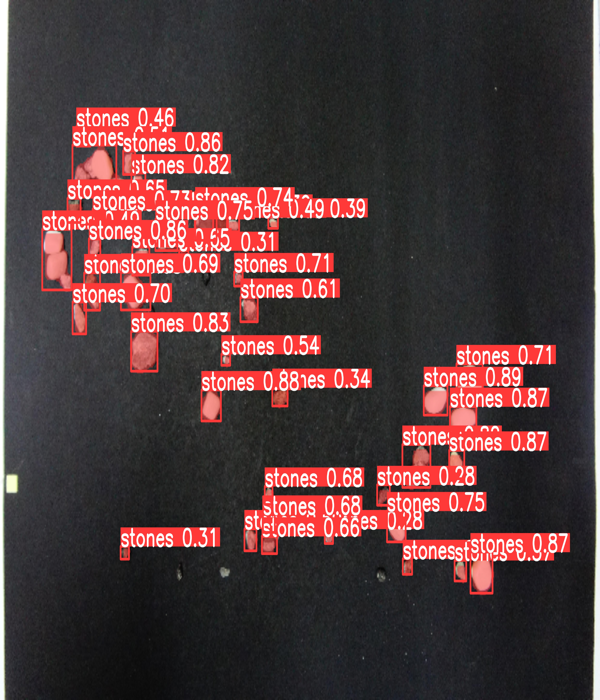

In [32]:
Image.open('runs/segment/predict/Image06.JPG').resize((600, 700))